## 훈련과정 : R·파이썬 기반 빅데이터 분석 전문가 양성과정
- 교과목 평가 : 머신러닝 기반 데이터 분석
- 성명 : 위정훈
- 점수 :

### Q. 아래사항을 준수하여 타이타닉 생존자 예측모델을 개발하세요.

- 데이터 : 
  - 제공 데이터 파일 : titanic3.csv
  - 훈련/검증용 데이터 : 평가 데이터 = 8 : 2
  - 훈련/검증용 데이터로 모델 학습 및 검증하고 평가 데이터는 최종 평가에만 사용


- 모델 개발 방법 :
  - 데이터 전처리 및 탐색적 분석을 통하여 파생변수 최소 2개 이상 개발
  - 알고리즘은 최소한 3개 이상 적용(Decision Tree, Random Forest, Logistic Regression은 필수)


- 훈련 및 평가 방법 :
  - GridSearchCV API를 활용하여 교차검증 및 최적 하이퍼파라미터 찾아서 학습 및 검증 수행

# import libraries and set korean font

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm  # 폰트 관련 용도

# import data file

In [110]:
tt = pd.read_csv('titanic3.csv')
display (tt.sample(5))

snstt = sns.load_dataset('titanic')
display (snstt.sample(5))

print ('\n', tt.info())
print ('\n', snstt.info())

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
971,3,0,"Linehan, Mr. Michael",male,NaN,0,0,330971,7.8792,NaN,Q,NaN,NaN,NaN
1188,3,1,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G6,S,13,NaN,NaN
397,2,0,"Downton, Mr. William James",male,54.0,0,0,28403,26.0000,NaN,S,NaN,NaN,"Holley, NY"
20,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,D35,S,5,NaN,"New York, NY"
934,3,1,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S,2,NaN,NaN


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
14,0,3,female,14.0,0,0,7.8542,S,Third,child,False,NaN,Southampton,no,True
484,1,1,male,25.0,1,0,91.0792,C,First,man,True,B,Cherbourg,yes,False
524,0,3,male,NaN,0,0,7.2292,C,Third,man,True,NaN,Cherbourg,no,True
83,0,1,male,28.0,0,0,47.1000,S,First,man,True,NaN,Southampton,no,True
478,0,3,male,22.0,0,0,7.5208,S,Third,man,True,NaN,Southampton,no,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB

 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
emb

In [150]:
# display (tt['ticket'].value_counts())
# print (tt['ticket'].unique())
# display (tt['ticket'].unique().tolist())
# filt = tt.groupby(['embarked']).filter(lambda x : x.str.contains('S') )
# display (filt)

# display (tt[['embarked','ticket']][  tt['ticket'].str.contains('A') ] )
# print ( tt[  tt['ticket'].str.contains(' ') ].groupby(['embarked'])['ticket'].head() )
display ( tt[  tt['ticket'].str.contains(' ') ].groupby(['embarked', 'home.dest'])['ticket'].unique() )
# print (tt[['embarked','ticket']][  tt['ticket'].str.contains('A') ].describe() )

embarked  home.dest                                     
C         ?Havana, Cuba                                                         [PC 17562]
          Austria-Hungary / Germantown, Philadelphia, PA                        [PC 17755]
          Barcelona, Spain / Havana, Cuba                   [SC/PARIS 2149, SC/PARIS 2148]
          Belgium  Montreal, PQ                                                 [PC 17482]
          Berne, Switzerland / Central City, IA                                  [SC 1748]
                                                                         ...              
S         West Bromwich, England Pontiac, MI                        [A/4 48871, A/4 48873]
          West Hampstead, London / Neepawa, MB                              [S.O.C. 14879]
          Weston-Super-Mare, Somerset                                         [SC/AH 3085]
          Wiltshire, England Niagara Falls, NY                                   [CA 2144]
          Winnipeg, MB           

In [0]:
display ( tt[  tt['ticket'].str.contains(' ') ].groupby(['embarked', 'home.dest'])['ticket'].unique() )

# Preprocessing

## ***drop unnecessary columns***

생존률에 영향을 미치기 어려운 columns 삭제

In [0]:
tt.drop(['name','ticket','embarked','body','home.dest','boat', ], axis=1, inplace=True)

cabin 값이 있는 경우는 대부분 pclass==1인 경우, 반대로 cabin 값이 null 인경우 대다수가 pclass==3 

따라서 cabin column은 pclass column과의 연관성이 커보이므로 삭제


In [29]:
print (tt['pclass'][tt.cabin.notnull()].value_counts(), '\n')
print (tt['pclass'][tt.cabin.isnull()].value_counts(), '\n')

tt.drop('cabin', axis=1, inplace=True)

display (tt.head())

1    256
2     23
3     16
Name: pclass, dtype: int64 

3    693
2    254
1     67
Name: pclass, dtype: int64 



,pclass,survived,sex,age,sibsp,parch,fare
0,1,1,female,29.00,0,0,211.3375
1,1,1,male,0.92,1,2,151.5500
2,1,0,female,2.00,1,2,151.5500
3,1,0,male,30.00,1,2,151.5500
4,1,0,female,25.00,1,2,151.5500


## ***null data formatting***

 - `isnull().sum()` 함수 통해 null 값 있는 columns 확인
 - `unique()` 함수 통해 data들의 형태 확인

In [32]:
print (tt.isnull().sum())
print ( f'{tt.age.unique()}\n\n{tt.fare.unique()}\n\n')
print ( f'{tt.age.nunique()}\n\n{tt.fare.nunique()}\n\n')

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
dtype: int64
[29.    0.92  2.   30.   25.   48.   63.   39.   53.   71.   47.   18.
 24.   26.   80.     nan 50.   32.   36.   37.   42.   19.   35.   28.
 45.   40.   58.   22.   41.   44.   59.   60.   33.   17.   11.   14.
 49.   76.   46.   27.   64.   55.   70.   38.   51.   31.    4.   54.
 23.   43.   52.   16.   32.5  21.   15.   65.   28.5  45.5  56.   13.
 61.   34.    6.   57.   62.   67.    1.   12.   20.    0.83  8.    0.67
  7.    3.   36.5  18.5   5.   66.    9.    0.75 70.5  22.5   0.33  0.17
 40.5  10.   23.5  34.5  20.5  30.5  55.5  38.5  14.5  24.5  60.5  74.
  0.42 11.5  26.5 ]

[211.3375 151.55    26.55    77.9583   0.      51.4792  49.5042 227.525
  69.3     78.85    30.      25.925  247.5208  76.2917  75.2417  52.5542
 221.7792  26.      91.0792 135.6333  35.5     31.     164.8667 262.375
  55.      30.5     50.4958  39.6     27.7208 134.5     26.2875  

### age column

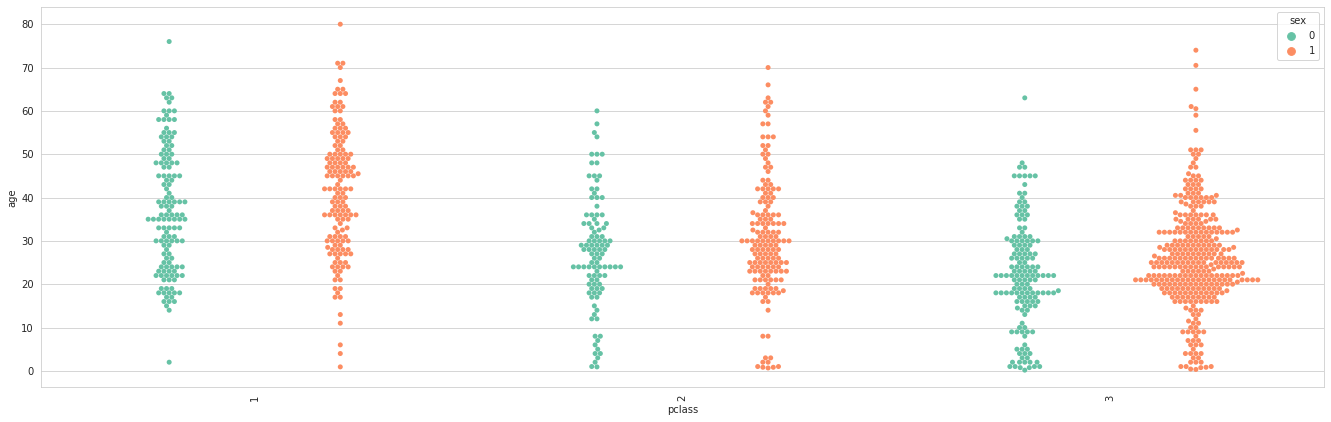

In [59]:
sns.set_style ('whitegrid')
fig = plt.figure(figsize=(23,7))
ax1 = fig.add_subplot(1,1,1)
plt.xticks(rotation=90)
sns.swarmplot(x='pclass', y = 'age',data = tt, hue='sex', palette='Set2', ax=ax1, dodge=True)

plt.show()
plt.close()

pclass 와 sex 에 따라 age의 평균값과 최빈값이 다름을 확인

- pclass가 올라갈수록 mean - mode 모두 증가
- 평균나이는 남성이 여성 보다 많지만, mode는 남성이 더 어림

In [34]:
print (tt.age.mean(), '\t',tt.age.median(), '\n')
print (tt['age'][tt['pclass']==3].count(), tt['age'][tt['pclass']==3].mean(), tt['age'][tt['pclass']==3].mode())
print (tt['age'][tt['pclass']==2].count(), tt['age'][tt['pclass']==2].mean(), tt['age'][tt['pclass']==2].mode())
print (tt['age'][tt['pclass']==1].count(), tt['age'][tt['pclass']==1].mean(), tt['age'][tt['pclass']==1].mode())
print (tt['age'][tt['sex']=='female'].count(), tt['age'][tt['sex']=='female'].mean(), tt['age'][tt['sex']=='female'].mode())
print (tt['age'][tt['sex']=='male'].count(), tt['age'][tt['sex']=='male'].mean(), tt['age'][tt['sex']=='male'].mode())

29.881137667304014 	 28.0 

501 24.81636726546906 0    22.0
dtype: float64
261 29.506704980842912 0    24.0
dtype: float64
284 39.15992957746479 0    36.0
dtype: float64
388 28.68708762886598 0    22.0
dtype: float64
658 30.58522796352583 0    21.0
dtype: float64


sibsp / parch에 따라 age의 mean-median-mode 달라지는 것 확인

- 전체 age 데이터
- 형제+배우자가 동승하지 않은 경우 (sibsp == 0)
- 부모+자녀가 동승하지 않은 경우 (parch == 0)
- 형제+배우자가 동승한 경우 (sibsp > 0)
- 부모+자녀가 동승한 경우 (parch > 0)
- 부모자녀 또는 형제배우자 동승자 없는 경우
- 부모자녀 또는 형제배우자 동승자 있는 경우


특히 부모자녀 동승자 있는 경우 미성년자 비율이 상대적으로 많아 mode가 2.0으로 극단적으로 낮아지는 경우 발생
- 다만 대상 숫자가 많지는 않음

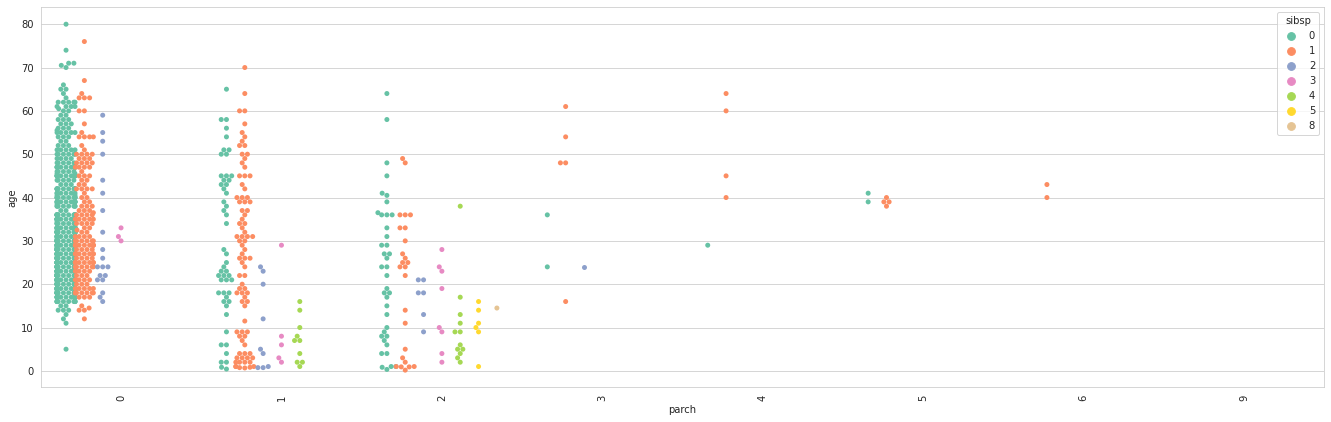

In [60]:
sns.set_style ('whitegrid')
fig = plt.figure(figsize=(23,7))
ax1 = fig.add_subplot(1,1,1)
plt.xticks(rotation=90)
sns.swarmplot(x='parch', y = 'age',data = tt, hue='sibsp', palette='Set2', ax=ax1, dodge=True)

plt.show()
plt.close()

In [62]:
# print (tt.sibsp.unique())
# print (tt.parch.unique())

print ('age 전체 데이터\n', tt['age'].describe(), tt['age'].mode() )
print ('부모자녀 동승자 없는 경우\n' , tt['age'][ tt['parch']==0 ].describe(), tt['age'][ tt['parch']==0 ].mode(), '\n',)
print ('형제배우자 동승자 없는 경우\n' ,tt['age'][ tt['sibsp']==0 ].describe(), tt['age'][ tt['sibsp']==0 ].mode(), '\n',)
print ('부모자녀 동승자 있는 경우\n' , tt['age'][ tt['parch'] > 0 ].describe(), tt['age'][ tt['parch'] > 0 ].mode(), '\n',)
print ('형제배우자 동승자 있는 경우\n' ,tt['age'][ tt['sibsp'] > 0 ].describe(), tt['age'][ tt['sibsp'] > 0 ].mode(), '\n',)
print ('부모자녀나 형제배우자 동승자 없는 경우\n' , tt['age'][(tt['parch']==0) | (tt['sibsp']==0) ].describe(), tt['age'][(tt['parch']==0) | (tt['sibsp']==0) ].mode(), '\n',)
print ('부모자녀나 형제배우자 동승자 있는 경우\n' , tt['age'][((tt['parch'] > 0) | (tt['sibsp'] > 0))].describe(), tt['age'][((tt['parch'] > 0) | (tt['sibsp'] > 0))].mode(), '\n',)

age 전체 데이터
 count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: age, dtype: float64 0    24.0
dtype: float64
부모자녀 동승자 없는 경우
 count    768.000000
mean      31.969401
std       12.422617
min        5.000000
25%       22.000000
50%       29.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64 0    24.0
1    30.0
dtype: float64 

형제배우자 동승자 없는 경우
 count    685.000000
mean      30.921766
std       13.059751
min        0.330000
25%       22.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64 0    22.0
dtype: float64 

부모자녀 동승자 있는 경우
 count    278.000000
mean      24.112122
std       17.633611
min        0.170000
25%        8.000000
50%       22.000000
75%       38.000000
max       70.000000
Name: age, dtype: float64 0    2.0
dtype: float64 

형제배우자 동승자 있는 경우
 count    361.000000
mean      27.906537
std       16.52

age가 null data 이면서, parch가 있는 case는 총 29개

In [63]:
# display (tt[tt['age'].isnull()][tt.parch > 0].values.tolist() , )
print ('\n', tt[tt['age'].isnull()][tt.parch > 0].count() ,'\n', )


 pclass      29
survived    29
sex         29
age          0
sibsp       29
parch       29
fare        29
age_24      29
age_mean    29
fam         29
dtype: int64 



age column의 상위 5개-10개 value_counts와 그 index의 mean 탐색

- 상위 5개 mean == 23
- 상위 10개 mean == 26
- mode == 24


AxesSubplot(0.125,0.125;0.775x0.755) 

24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
Name: age, dtype: int64
Float64Index([24.0, 22.0, 21.0, 30.0, 18.0], dtype='float64')
0    23.0
dtype: float64

24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
25.0    34
28.0    32
36.0    31
27.0    30
29.0    30
Name: age, dtype: int64
Float64Index([24.0, 22.0, 21.0, 30.0, 18.0, 25.0, 28.0, 36.0, 27.0, 29.0], dtype='float64')
0    26.0
dtype: float64


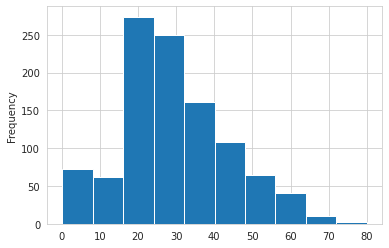

In [64]:
print (tt.age.plot(kind='hist'), '\n')

print (tt.age.value_counts().head(5))
print (tt.age.value_counts().head(5).keys())
print (pd.DataFrame(tt.age.value_counts().head(5).keys()).mean())
print ()
print (tt.age.value_counts().head(10))
print (tt.age.value_counts().head(10).keys())
print (pd.DataFrame(tt.age.value_counts().head(10).keys()).mean())

age column을 다음 세 columns로 분리

평균치 29를 적용하는 것 보다는 대부분의 경우에서 최빈값으로 나오는 24를 적용하는 것이 오차범위를 줄일 것으로 가정하고 `fillna(24)` 적용

 - 현재 age column : null data 그대로 적용
 - age_24 : 전체 null data에 `fillna(value=tt.age.mode())` 적용
 - age_mean : 전체 null data에 `fillna(value=tt.age.mean())` 적용

 <!-- - age_notp : parch == 0 인 경우만 `fillna(24)` 적용, parch > 0 인 경우 null -->
 <!-- - age_cls : null data에 해당 plclass 의 최빈값 적용, `fillna(value=tt['age'][tt.pclass==n].mode())`  -->

In [65]:
# print (tt.age.isnull().sum(),'\n')

tt['age_24'] = tt.age.fillna(value = 24, inplace=False)
print (tt.age_24.isnull().sum(), '\n')

tt['age_mean'] = tt.age.fillna(value = round(tt.age.mean(), 2), inplace=False)
print (tt.age_mean.isnull().sum(), '\n')

# display (tt['age'][tt.parch == 0].head(5))
# tt['age_notp'] = tt['age']
# print (tt[tt.parch == 0]['age_notp'].head(), len(tt[tt.parch == 0]['age_notp']))
# print (len(tt[tt.parch==0]))
# tt.loc['age_notp'].fillna(value = tt.age.mode(), inplace=True, )
# print (tt.age_notp.isnull().sum(), '\n')

display(tt[tt.age.isnull()].head(10))

0 

0 



,pclass,survived,sex,age,sibsp,parch,fare,age_24,age_mean,fam
15,1,0,1,NaN,0,0,25.9250,24.0,29.88,0
37,1,1,1,NaN,0,0,26.5500,24.0,29.88,0
40,1,0,1,NaN,0,0,39.6000,24.0,29.88,0
46,1,0,1,NaN,0,0,31.0000,24.0,29.88,0
59,1,1,0,NaN,0,0,27.7208,24.0,29.88,0
69,1,1,0,NaN,0,1,55.0000,24.0,29.88,1
70,1,0,1,NaN,0,0,0.0000,24.0,29.88,0
74,1,0,1,NaN,0,0,52.0000,24.0,29.88,0
80,1,0,1,NaN,0,0,26.5500,24.0,29.88,0
106,1,0,1,NaN,0,0,221.7792,24.0,29.88,0


fare columns의 null data에는 해당 pclass의 평균값 입력

In [66]:
# print (tt[tt['fare'].isnull()])
# print (tt[ tt['fare'].isnull() ]['pclass'].max())
print (tt['fare'][tt['pclass']==3].mean())
print (tt['fare'][tt['pclass']==tt[ tt['fare'].isnull() ]['pclass'].max()].mean())

13.302888700564958
nan


In [67]:
tt.fare.fillna(value = (tt['fare'][tt['pclass']==tt[ tt['fare'].isnull() ]['pclass'].max()].mean()), inplace=True)
print (tt.fare.isnull().sum())

# tt.drop(['age_cls','age_notp'], axis=1, inplace=True)

0


## ***fit_transforming***

- boat column의 type을 int로 변경 ; boat 탑승 여부
- label encoding ; sex, boat
- sibsp와 parch를 합친 fam 변수 생성

In [0]:
# tt.boat = tt.boat.notnull().astype(int)

tt.sex = LabelEncoder().fit_transform(tt.sex)
# tt.boat = LabelEncoder().fit_transform(tt.boat)

tt['fam'] = tt.sibsp+tt.parch

In [69]:
display (tt.head(10))

,pclass,survived,sex,age,sibsp,parch,fare,age_24,age_mean,fam
0,1,1,0,29.00,0,0,211.3375,29.00,29.00,0
1,1,1,1,0.92,1,2,151.5500,0.92,0.92,3
2,1,0,0,2.00,1,2,151.5500,2.00,2.00,3
3,1,0,1,30.00,1,2,151.5500,30.00,30.00,3
4,1,0,0,25.00,1,2,151.5500,25.00,25.00,3
5,1,1,1,48.00,0,0,26.5500,48.00,48.00,0
6,1,1,0,63.00,1,0,77.9583,63.00,63.00,1
7,1,0,1,39.00,0,0,0.0000,39.00,39.00,0
8,1,1,0,53.00,2,0,51.4792,53.00,53.00,2
9,1,0,1,71.00,0,0,49.5042,71.00,71.00,0


## ***각 변수간 상관관계 분석 : `corr()`***

- 각 변수간 단일 상관관계 분석
- survived와 상관관계가 높은 변수는 boat (0.948190) - sex(-0.528693) - pclass(-0.312469) 순
    - age의 경우 전반적으로 상관관계는 미미함
    - null data를 변형하지 않은 original age data의 상관관계(-0.055512)가 평균값 적용한 age_mean(-0.050195)과 최빈값 적용한 (-0.029985)보다 더 큼

- fare, age와 pclass는 각각 -0.558694, -0.408106로 유의미한 관계로 보임
    - 그러나 null data 때문에 모델링 불가능 하므로, 차선책으로 age_24 사용
- sex - boat의 상관관계는 -0.482086으로 유의미한 관계로 보임

따라서 종속변수 survived에 대한 독립변수 fare, age_24, boat, pclass, sex를 유의미한 변수로 보고 모델링

In [89]:
display (tt.corr())

,pclass,survived,sex,age,sibsp,parch,fare,age_24,age_mean,fam
pclass,1.000000,-0.312469,0.124617,-0.408106,0.060832,0.018322,-0.558694,-0.397857,-0.366378,0.050027
survived,-0.312469,1.000000,-0.528693,-0.055512,-0.027825,0.082660,0.244426,-0.029985,-0.050195,0.026876
sex,0.124617,-0.528693,1.000000,0.063645,-0.109609,-0.213125,-0.185693,0.045259,0.057395,-0.188583
age,-0.408106,-0.055512,0.063645,1.000000,-0.243699,-0.150917,0.177485,1.000000,1.000000,-0.240229
sibsp,0.060832,-0.027825,-0.109609,-0.243699,1.000000,0.373587,0.160357,-0.186248,-0.190747,0.861952
parch,0.018322,0.082660,-0.213125,-0.150917,0.373587,1.000000,0.221641,-0.113955,-0.130869,0.792296
fare,-0.558694,0.244426,-0.185693,0.177485,0.160357,0.221641,1.000000,0.191502,0.170814,0.226617
age_24,-0.397857,-0.029985,0.045259,1.000000,-0.186248,-0.113955,0.191502,1.000000,0.983674,-0.184791
age_mean,-0.366378,-0.050195,0.057395,1.000000,-0.190747,-0.130869,0.170814,0.983674,1.000000,-0.196994
fam,0.050027,0.026876,-0.188583,-0.240229,0.861952,0.792296,0.226617,-0.184791,-0.196994,1.000000


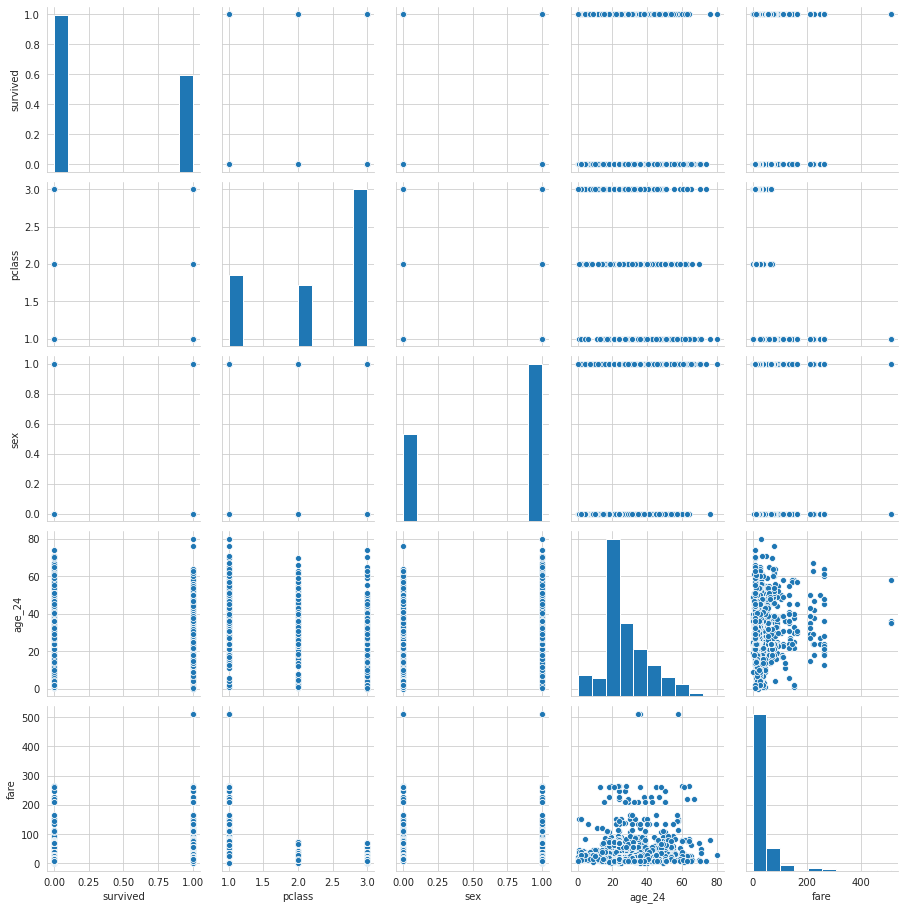

In [71]:
sns.pairplot(tt[['survived','pclass','sex','age_24','fare',]])
plt.show () ; plt.close()

# `train_test_split`

- 위에서 선택한 독립변수들만 표준정규화

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x = tt[['fare','age_24','pclass', 'sex']]
x = StandardScaler().fit_transform(x)

y = tt['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print (f'x_train : {x_train.shape}\tx_test : {x_test.shape}\ty_train : {y_train.shape}\ty_test : {y_test.shape}\t')

x_train : (1047, 4)	x_test : (262, 4)	y_train : (1047,)	y_test : (262,)	


# Modeling & 교차검증

## Modeling
- Decision Tree
- Random Forest
- Logistic Regression

## CVS
- cross-val-scores
- GridSearchCV

In [0]:
# Modeling & Score
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# CVS
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

### Decision Tree

In [74]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dtpr = dt.predict(x_test)
dtacc = accuracy_score(y_test, dtpr)
print (f'DT 예측 정확도 : {round(dtacc, 2)}')

DT 예측 정확도 : 0.77


In [75]:
cvs = cross_val_score(dt, x, y, cv=10)
for count, acc in enumerate(cvs) :
    print (f'교차 검증 {count+1} 정확도 : {round(acc, 4)}')
print (f'평균 정확도 : {round(np.mean(cvs), 4)}')

교차 검증 1 정확도 : 0.7099
교차 검증 2 정확도 : 0.7634
교차 검증 3 정확도 : 0.8015
교차 검증 4 정확도 : 0.7176
교차 검증 5 정확도 : 0.7634
교차 검증 6 정확도 : 0.7481
교차 검증 7 정확도 : 0.6565
교차 검증 8 정확도 : 0.6489
교차 검증 9 정확도 : 0.6489
교차 검증 10 정확도 : 0.7385
평균 정확도 : 0.7196


In [76]:
%time

dtparams = {
    'max_depth' : [2,3,5],
    'min_samples_split' : [2,3,4, 5, 10, 20, 50, 100],
    'min_samples_leaf' : [1,2,3,5,9],
}
dtgrid = GridSearchCV(estimator = dt, param_grid=dtparams, scoring='accuracy', cv=10, refit=True)
dtgrid.fit(x_train, y_train)
print (f'최적 hyper parameter : {dtgrid.best_params_}\n최고 정확도 : {dtgrid.best_score_}')
best_dt = dtgrid.best_estimator_
best_dtpr = best_dt.predict(x_test)
dtacc = accuracy_score(y_test, best_dtpr)
print (f'예측 정확도 : {dtacc}')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
최적 hyper parameter : {'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 20}
최고 정확도 : 0.7993131868131867
예측 정확도 : 0.8129770992366412


### Random Forest

In [77]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rfpr = rf.predict(x_test)
rfacc = accuracy_score(y_test, rfpr)
print (f'RF 예측 정확도 : {round(rfacc, 2)}')

RF 예측 정확도 : 0.8


In [78]:
cvs = cross_val_score(rf, x, y, cv=10)
for count, acc in enumerate(cvs) :
    print (f'교차 검증 {count+1} 정확도 : {round(acc, 4)}')
print (f'평균 정확도 : {round(np.mean(cvs), 4)}')

교차 검증 1 정확도 : 0.6947
교차 검증 2 정확도 : 0.8244
교차 검증 3 정확도 : 0.8626
교차 검증 4 정확도 : 0.8015
교차 검증 5 정확도 : 0.7939
교차 검증 6 정확도 : 0.8244
교차 검증 7 정확도 : 0.7176
교차 검증 8 정확도 : 0.6412
교차 검증 9 정확도 : 0.6565
교차 검증 10 정확도 : 0.7462
평균 정확도 : 0.7563


In [88]:
%time

rfparams = {
    'n_estimators' : [10,50,100,150],
    'max_depth' : [2, 5, 10, 20, 50, 100],
    'min_samples_leaf' : [1,3,5,9],
}
rfgrid = GridSearchCV(estimator = rf, param_grid=rfparams, scoring='accuracy', cv=10, refit=True)
rfgrid.fit(x_train, y_train)
print (f'최적 hyper parameter : {rfgrid.best_params_}\n최고 정확도 : {rfgrid.best_score_}')
best_rf = rfgrid.best_estimator_
best_rfpr = best_rf.predict(x_test)
rfacc = accuracy_score(y_test, best_rfpr)
print (f'예측 정확도 : {rfacc}')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
최적 hyper parameter : {'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 100}
최고 정확도 : 0.8194322344322345
예측 정확도 : 0.816793893129771


### Logistic Regression

In [87]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lrpr = lr.predict(x_test)
lracc = accuracy_score(y_test, lrpr)
print (f'LR 예측 정확도 : {round(lracc, 2)}')

LR 예측 정확도 : 0.79


In [86]:
cvs = cross_val_score(lr, x, y, cv=10)
for count, acc in enumerate(cvs) :
    print (f'교차 검증 {count+1} 정확도 : {round(acc, 4)}')
print (f'평균 정확도 : {round(np.mean(cvs), 4)}')

교차 검증 1 정확도 : 0.6031
교차 검증 2 정확도 : 0.7786
교차 검증 3 정확도 : 0.8473
교차 검증 4 정확도 : 0.8015
교차 검증 5 정확도 : 0.8015
교차 검증 6 정확도 : 0.8015
교차 검증 7 정확도 : 0.7252
교차 검증 8 정확도 : 0.6718
교차 검증 9 정확도 : 0.7252
교차 검증 10 정확도 : 0.7462
평균 정확도 : 0.7502


In [85]:
import warnings
warnings.filterwarnings('ignore')
%time

lrparams = {
    'penalty' : ['l1','l2','none', ],
    'C' : [0.0001, 0.001, 0.01, 0.1, 1, 2, ],
}
lrgrid = GridSearchCV(estimator = lr, param_grid=lrparams, scoring='accuracy', cv=10, refit=True)
lrgrid.fit(x_train, y_train)
print (f'최적 hyper parameter : {lrgrid.best_params_}\n최고 정확도 : {lrgrid.best_score_}')
best_lr = lrgrid.best_estimator_
best_lrpr = best_lr.predict(x_test)
lracc = accuracy_score(y_test, best_lrpr)
print (f'예측 정확도 : {lracc}')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
최적 hyper parameter : {'C': 0.01, 'penalty': 'l2'}
최고 정확도 : 0.7792582417582417
예측 정확도 : 0.8053435114503816


# Conclusion

전체 데이터 중 상관계수가 높은 변수 ***'sex', 'fare', 'pclass', 'age_24'***를 선택하여, Decision Tree 방식으로 Modeling 을 할 경우, 

예측 정확도 ***81.29%***로 생존자를 예측할 수 있다.




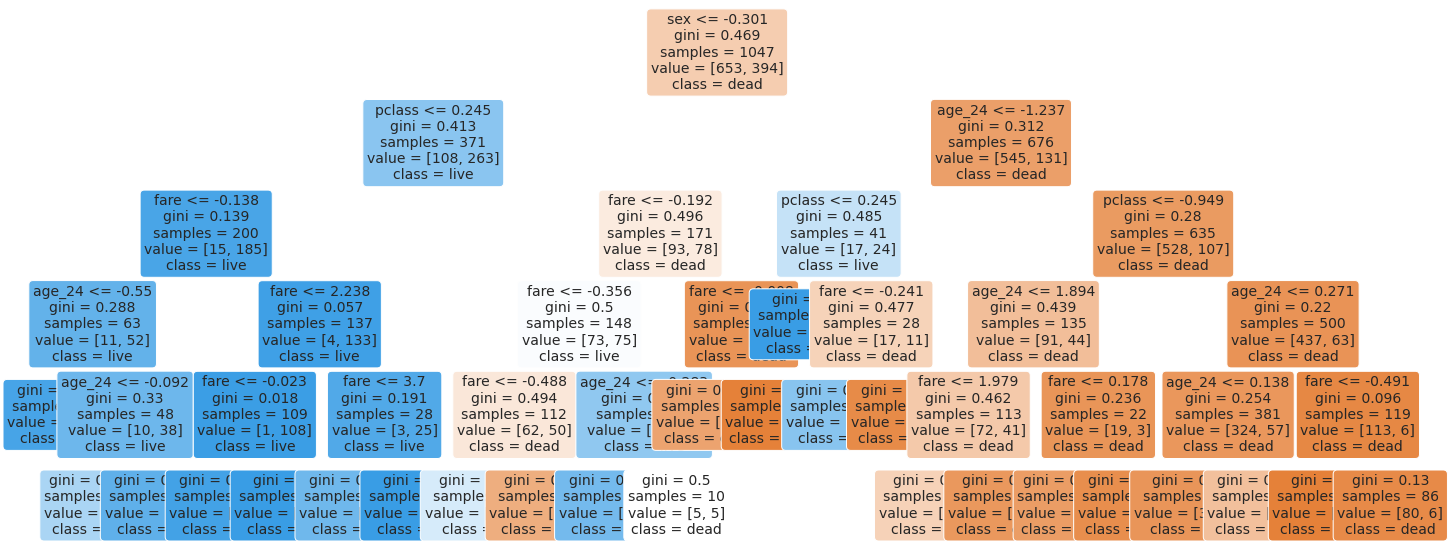

In [84]:
plt.figure(figsize=(25,10))
tree.plot_tree(best_dt, filled=True, feature_names = ['fare','age_24','pclass', 'sex'], class_names = ['dead','live'], rounded=True, fontsize = 14)

plt.show() ; plt.close()